# Image Denoising

In [2]:
from h5py import File as h5pyFile

with h5pyFile("data/assignmentImageDenoising_chestCT.mat", "r") as file:
    image_raw = file["imageChestCT"][:]

import numpy as np

image = np.array(image_raw).astype(np.float32)
image = (image - np.min(image)) / (np.max(image) - np.min(image))
image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(512, 512), dtype=float32)

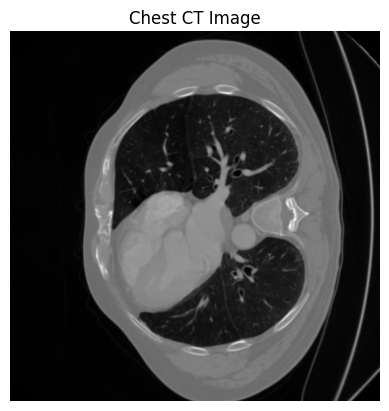

In [3]:
import matplotlib.pyplot as plt


def show_image(image_data: np.ndarray, title: str = "") -> None:
    plt.title(title)
    plt.imshow(image_data, cmap="gray")
    plt.axis("off")
    plt.show()


show_image(image, title="Chest CT Image")

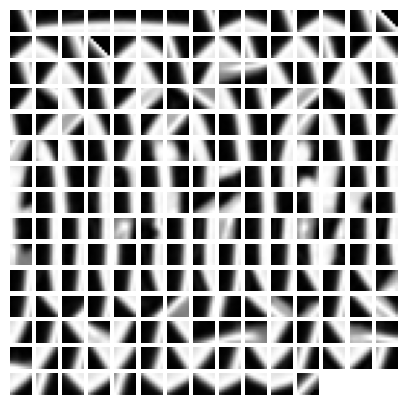

222

In [16]:
def get_patches(main_image: np.ndarray, var_thresh: float = 0.03, plot: bool = True,
                patch_size=(8, 8)) -> np.ndarray:
    image_patches = []
    i = 0
    while i <= main_image.shape[0] - patch_size[0]:
        j = 0
        while j <= main_image.shape[1] - patch_size[1]:
            patch = main_image[i:(i + patch_size[0]), j:(j + patch_size[1])]
            if np.var(patch) > var_thresh:
                image_patches.append(patch.flatten())
                j += patch_size[1]
            else:
                j += 1
        i += patch_size[0]

    if plot:
        grid_size = int(np.sqrt(len(image_patches))) + 1
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, ax in enumerate(axes.flat):
            if i < len(image_patches):
                patch = image_patches[i].reshape(patch_size)
                ax.imshow(patch, cmap="gray")
            ax.axis("off")
        plt.show()

    return np.array(image_patches)


patches = get_patches(image)
len(patches)

Iteration 0: Objective 1274.3640
Iteration 100: Objective 330.6163
Iteration 200: Objective 293.1570
Iteration 300: Objective 277.7742
Iteration 400: Objective 269.2518


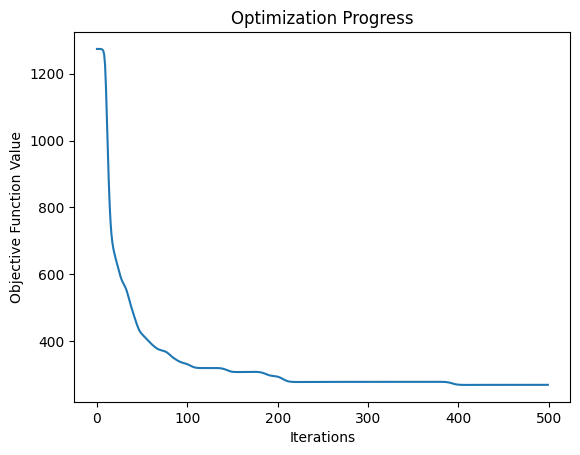

array([[-0.00739593, -0.15517493,  0.00732167, ...,  0.01779066,
         0.04783989,  0.04709254],
       [-0.01780062, -0.13722727,  0.01769614, ...,  0.00960556,
        -0.07883044, -0.07710169],
       [-0.03426651, -0.10999583,  0.03412402, ..., -0.07215208,
         0.07723721,  0.10541314],
       ...,
       [-0.1395946 , -0.09168378,  0.13980588, ..., -0.01917519,
         0.02299242,  0.01321759],
       [-0.1888869 , -0.05264376,  0.18907738, ..., -0.02623231,
        -0.03330782,  0.01057445],
       [-0.21528852, -0.02353177,  0.21543878, ...,  0.02378004,
         0.01748954, -0.01806389]], shape=(64, 64), dtype=float32)

In [17]:
def normalize_columns(d):
    """Normalize columns of D to have unit norm."""
    norms = np.linalg.norm(d, axis=0, keepdims=True)
    norms = np.maximum(norms, 1e-8)  # Prevent division by zero
    return d / norms


def objective_function(x, d, r, lambda_, p):
    """Compute the objective function value."""
    reconstruction_error = np.sum(np.linalg.norm(x.T - d @ r, ord=2, axis=0) ** 2)
    regularization = lambda_ * np.sum(np.linalg.norm(r, ord=p, axis=0) ** p)
    return reconstruction_error + regularization


def sparse_coding(x, d, lambda_, p=0.5, lr=0.001, n_iter=50):
    """Solve for r using p-norm regularization when p < 1."""
    n_samples, n_features = x.shape
    n_components = d.shape[1]
    r = np.zeros((n_components, n_samples))

    for _ in range(n_iter):
        gradient = -2 * d.T @ (x.T - d @ r)  # Gradient of reconstruction error

        # Avoid singularities in p-norm when p < 1
        sparsity_grad = lambda_ * p * np.sign(r) * np.maximum(np.abs(r), 1e-6) ** (p - 1)

        gradient += sparsity_grad

        r -= lr * gradient  # Gradient descent step

        # Optional: Clip large updates for stability
        r = np.clip(r, -10, 10)

    return r


def update_dictionary(d, x, r, learning_rate):
    """Gradient descent update for D."""
    gradient = np.zeros_like(d)
    for i in range(x.shape[0]):
        gradient += np.outer(x[i] - d @ r[:, i], r[:, i])

    d += learning_rate * gradient / np.linalg.norm(gradient)  # Normalize step size
    return normalize_columns(d)  # Ensure unit norm constraint


def dictionary_learning(x, p=1, n_components=64, lambda_=0.1, learning_rate=1, n_iter=500, plot=True):
    """Learn dictionary D using gradient descent and sparse coding."""
    n_samples, n_features = x.shape
    n_components = min(n_components, n_features)  # Ensure valid component count

    # Initialize dictionary using SVD
    v_t = np.linalg.svd(x, full_matrices=False)[2]
    d = normalize_columns(v_t.T[:, :n_components])

    objective_values = []

    for i in range(n_iter):
        r = sparse_coding(x, d, lambda_, p)

        obj_value = objective_function(x, d, r, lambda_, p)
        objective_values.append(obj_value)

        d = update_dictionary(d, x, r, learning_rate)

        if i % 100 == 0 and plot:
            print(f"Iteration {i}: Objective {obj_value:.4f}")

    if plot:
        plt.plot(range(n_iter), objective_values)
        plt.xlabel("Iterations")
        plt.ylabel("Objective Function Value")
        plt.title("Optimization Progress")
        plt.show()

    return d


dictionary_learning(patches)

Iteration 0: Objective 1258.2199
Iteration 100: Objective 86.1547
Iteration 200: Objective 88.3632
Iteration 300: Objective 88.3535
Iteration 400: Objective 88.3245


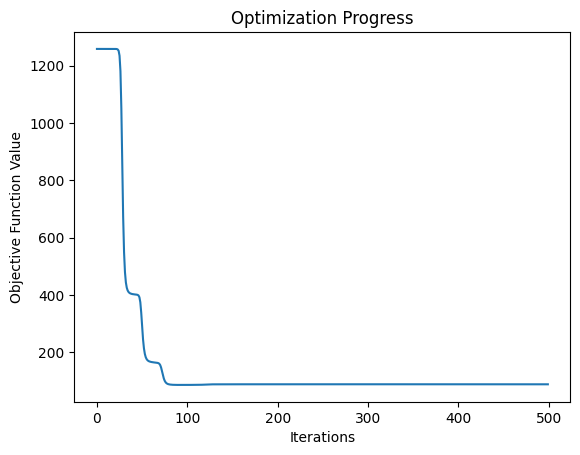

array([[-0.12361456, -0.14919657, -0.07744188, ...,  0.09869298,
        -0.16704386, -0.15136565],
       [-0.14870764, -0.13497394, -0.10793379, ...,  0.10858983,
        -0.15592942, -0.14162105],
       [-0.17636423, -0.11126497, -0.14691342, ...,  0.11604224,
        -0.1339536 , -0.12173605],
       ...,
       [ 0.06438456,  0.09559502,  0.22466101, ...,  0.10438475,
        -0.07086138, -0.10777386],
       [ 0.04184878,  0.15523438,  0.19825989, ...,  0.12282758,
        -0.03759413, -0.08425942],
       [ 0.00975489,  0.18491179,  0.15325268, ...,  0.13527504,
        -0.01565338, -0.06586742]], shape=(64, 64), dtype=float32)

In [18]:
dictionary_learning(patches, p=2)

Iteration 0: Objective 1261.0287
Iteration 100: Objective 99.0320
Iteration 200: Objective 97.4770
Iteration 300: Objective 97.0412
Iteration 400: Objective 97.0138


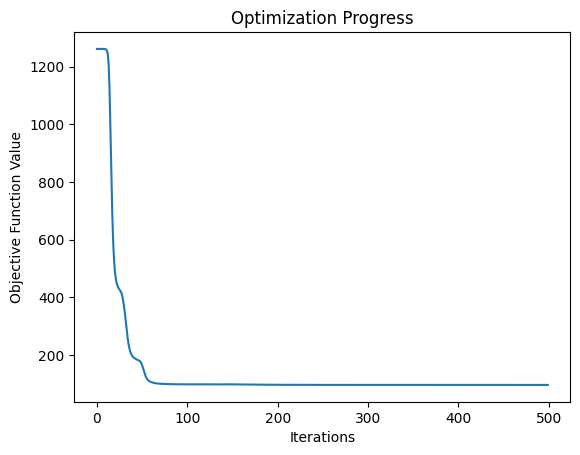

array([[-0.05903264, -0.09434164, -0.072422  , ..., -0.01998041,
        -0.00861532, -0.17870829],
       [-0.09975936, -0.07661895, -0.10693812, ...,  0.00218665,
        -0.03649959, -0.18758112],
       [-0.13931578, -0.04985067, -0.14938144, ...,  0.03243291,
        -0.0450781 , -0.18951513],
       ...,
       [ 0.04638664,  0.04426858,  0.21869555, ..., -0.03793226,
        -0.22512576,  0.14422229],
       [ 0.01127187,  0.12280321,  0.19698533, ...,  0.04596022,
        -0.16805738,  0.15229705],
       [-0.02970934,  0.17246345,  0.15573856, ...,  0.11013792,
        -0.12185013,  0.13671876]], shape=(64, 64), dtype=float32)

In [19]:
dictionary_learning(patches, p=1.6)

Iteration 0: Objective 1267.8316
Iteration 100: Objective 210.0372
Iteration 200: Objective 187.8959
Iteration 300: Objective 178.1605
Iteration 400: Objective 173.6444


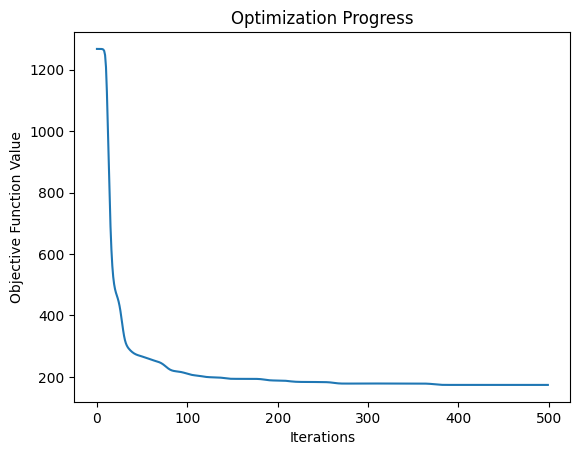

array([[ 0.00601607, -0.02035357, -0.01670659, ...,  0.01753491,
         0.04798038,  0.0472035 ],
       [-0.00701129, -0.00342226, -0.04564201, ...,  0.009511  ,
        -0.07875375, -0.07705924],
       [-0.02748903,  0.02224352, -0.08278371, ..., -0.07186639,
         0.07718506,  0.10539903],
       ...,
       [-0.12340686,  0.09716103,  0.25818703, ..., -0.0191202 ,
         0.02302409,  0.01322223],
       [-0.17911853,  0.15973207,  0.23828366, ..., -0.02628526,
        -0.03335588,  0.0106254 ],
       [-0.2110261 ,  0.19829245,  0.19879471, ...,  0.02385124,
         0.01748357, -0.01809504]], shape=(64, 64), dtype=float32)

In [20]:
dictionary_learning(patches, p=1.2)

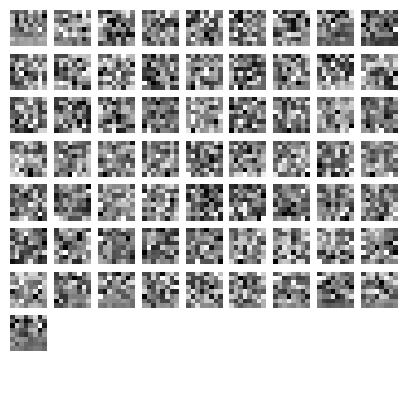

In [21]:
v_t = np.linalg.svd(patches, full_matrices=False)[2]
image_patches = normalize_columns(v_t.T[:, :64])

grid_size = int(np.sqrt(len(image_patches))) + 1
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axes.flat):
    if i < len(image_patches):
        patch = image_patches[i].reshape((8, 8))
        ax.imshow(patch, cmap="gray")
    ax.axis("off")
plt.show()

Iteration 0: Objective 1267.8316
Iteration 100: Objective 210.0372
Iteration 200: Objective 187.8959
Iteration 300: Objective 178.1605
Iteration 400: Objective 173.6444


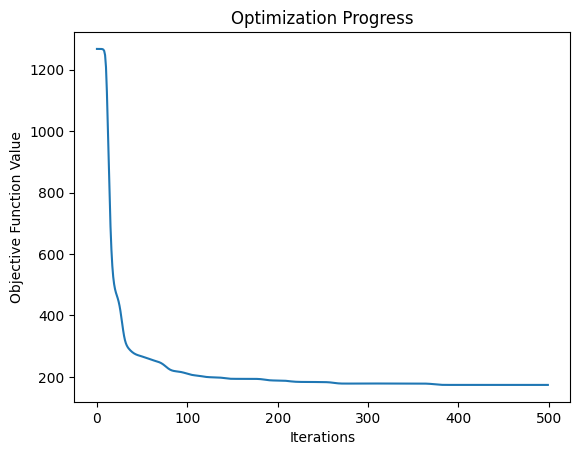

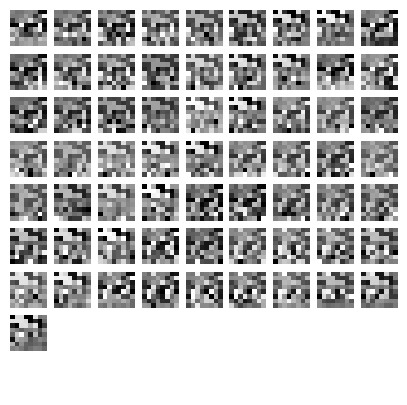

In [25]:
image_patches = normalize_columns(dictionary_learning(patches, p=1.2))

grid_size = int(np.sqrt(len(image_patches))) + 1
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5, 5))

for i, ax in enumerate(axes.flat):
    if i < len(image_patches):
        patch = image_patches[i].reshape((8, 8))
        ax.imshow(patch, cmap="gray")
    ax.axis("off")
plt.show()

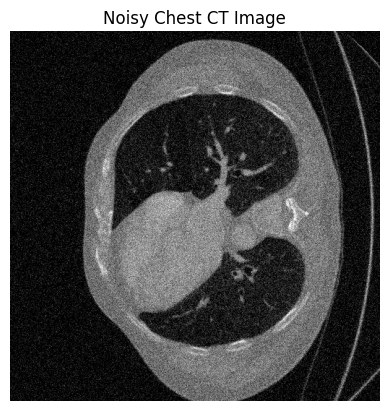

In [10]:
def add_gaussian_noise(main_image, std_ratio=0.1):
    noise_std = std_ratio * (main_image.max() - main_image.min())
    noisy_image = main_image + np.random.normal(0, noise_std, main_image.shape)
    return np.clip(noisy_image, 0, 1)


noisy = add_gaussian_noise(image)
show_image(noisy, title="Noisy Chest CT Image")

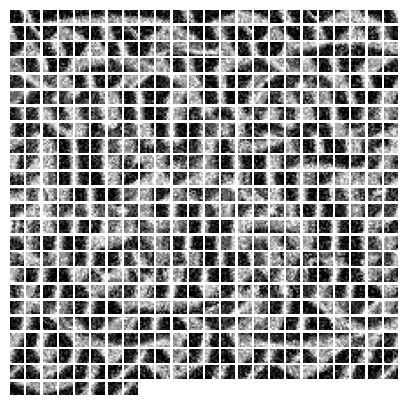

Iteration 0: Objective 3896.1811
Iteration 100: Objective 888.6136
Iteration 200: Objective 815.7573
Iteration 300: Objective 791.3001
Iteration 400: Objective 775.3139


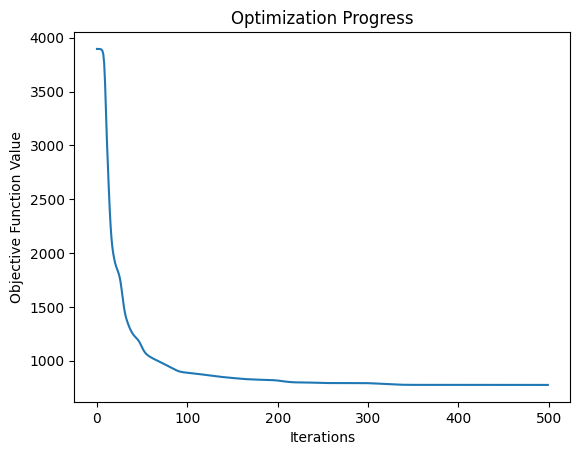

array([[-0.02796438, -0.0273233 ,  0.02327302, ..., -0.26337317,
        -0.13626411, -0.02767945],
       [-0.03207697, -0.03083854,  0.02574426, ..., -0.26155489,
        -0.11657683, -0.03767161],
       [-0.03499969, -0.03253986,  0.02869197, ..., -0.25259243,
        -0.10432906, -0.02445408],
       ...,
       [-0.15041171, -0.15133563,  0.16512056, ...,  0.07677509,
        -0.09273988,  0.02460807],
       [-0.20966378, -0.21237822,  0.22502114, ...,  0.02497569,
        -0.04781084, -0.02389554],
       [-0.26763468, -0.27190141,  0.28097221, ...,  0.01878196,
        -0.01162029, -0.11299703]], shape=(64, 64))

In [11]:
def rrmse(original_img: np.ndarray, noisy_img: np.ndarray) -> float:
    return np.sqrt(np.sum((original_img - noisy_img) ** 2) / np.sum(original_img ** 2))

noisy_patches = get_patches(noisy)
noise_dict = dictionary_learning(noisy_patches, p=0.8)
noise_dict

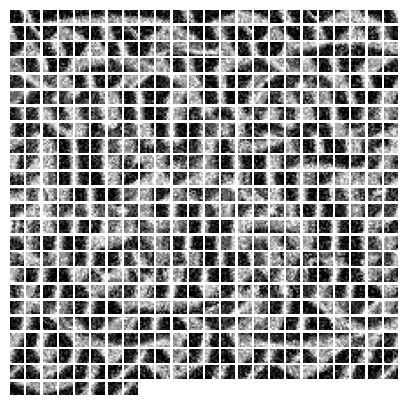

array([[0.09729991, 0.07837289, 0.        , ..., 0.10622902, 0.04209416,
        0.        ],
       [0.03697962, 0.        , 0.11575862, ..., 0.11205091, 0.        ,
        0.08687053],
       [0.08278077, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(512, 512))

In [12]:
def denoise_image(noisy_image, noise_patches_dict, p=2):
    noisy_img_patches = get_patches(noisy_image)
    denoised_patches = []

    for patch in noisy_img_patches:
        patch = patch.reshape(-1, 1)  # Reshape patch to 2D
        r = sparse_coding(patch, noise_patches_dict, lambda_=0.1, p=p, n_iter=50)
        denoised_patch = noise_patches_dict @ r
        denoised_patches.append(denoised_patch.flatten())  # Flatten the denoised patch

    denoised_image = np.zeros_like(noisy_image)
    i = 0
    patch_size = 8
    for j in range(0, noisy_image.shape[0] - patch_size + 1, patch_size):
        for k in range(0, noisy_image.shape[1] - patch_size + 1, patch_size):
            if i < len(denoised_patches):
                denoised_image[j:(j + patch_size), k:(k + patch_size)] = denoised_patches[i][:patch_size * patch_size].reshape(patch_size, patch_size)
                i += 1
            else:
                break

    return denoised_image

denoised_img = denoise_image(noisy, noise_dict)
denoised_img